In [1]:
import pandas as pd
import numpy as np
import os as os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import acessos as ac
import funcionalidade as fc
import re
from pylift import TransformedOutcome
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Obtenção de dados - fonte da tabela na pasta sql

In [2]:
query = """
  
select * from customer_sandbox_zone.dados_estudo_mgm_flavia

"""

df = ac.df_athena('flavia-costa', query)

In [4]:
len(df)

1035884

In [5]:
df.dtypes

cpf                          object
tempo_aprovacao             float64
tempo_relacionamento        float64
ganho_limite                float64
ds_risk_type                 object
gender                       object
nr_declared_income          float64
ds_region                    object
flag_autonomo                 int64
max_limite                  float64
max_qtd_if                    int64
avg_utilizado_interno       float64
sum_utilizado_interno       float64
avg_utilizado_mercado       float64
sum_utilizado_mercado       float64
nr_chaves_importantes       float64
nr_antecipacao_fatura       float64
nr_bolso_ativo              float64
nr_trans_mov_conta          float64
nr_purchases_virtual        float64
avg_vl_total_spending       float64
nr_purchases_online         float64
nr_acessos                  float64
pc_acessos_lojawill         float64
flag_mgm                    float64
dias_atraso                   int64
ordem                         int64
flag_limite_insuficiente    

In [6]:
df.isnull().sum()

cpf                              0
tempo_aprovacao               3171
tempo_relacionamento          3171
ganho_limite                120421
ds_risk_type                     0
gender                        9190
nr_declared_income               0
ds_region                       12
flag_autonomo                    0
max_limite                       0
max_qtd_if                       0
avg_utilizado_interno        97612
sum_utilizado_interno        97612
avg_utilizado_mercado        97612
sum_utilizado_mercado        97612
nr_chaves_importantes       375425
nr_antecipacao_fatura       375425
nr_bolso_ativo              375425
nr_trans_mov_conta          375425
nr_purchases_virtual        122126
avg_vl_total_spending       122126
nr_purchases_online         122126
nr_acessos                  500000
pc_acessos_lojawill         500000
flag_mgm                    500000
dias_atraso                      0
ordem                            0
flag_limite_insuficiente         0
share_of_wallet     

### Definindo tipos de var e lidando com missings

In [7]:
#variáveis para recodificar como zero
df['share_of_wallet'] = df['share_of_wallet'].fillna(0.0)
df['ganho_limite'] = df['ganho_limite'].fillna(0.0)

df['nr_purchases_online'] = df['nr_purchases_online'].fillna(0.0)
df['nr_acessos'] = df['nr_acessos'].fillna(0.0)
df['pc_acessos_lojawill'] = df['pc_acessos_lojawill'].fillna(0.0)
df['nr_chaves_importantes'] = df['nr_chaves_importantes'].fillna(0.0)

In [8]:
id_columns = ['cpf', 'ordem']
cat_columns = df.drop(id_columns, axis = 1).select_dtypes('object').columns
num_columns = df.drop(id_columns, axis = 1).select_dtypes(exclude=['object']).columns

In [9]:
df.drop(id_columns, axis=1).describe()

,tempo_aprovacao,tempo_relacionamento,ganho_limite,nr_declared_income,flag_autonomo,max_limite,max_qtd_if,avg_utilizado_interno,sum_utilizado_interno,avg_utilizado_mercado,...,nr_trans_mov_conta,nr_purchases_virtual,avg_vl_total_spending,nr_purchases_online,nr_acessos,pc_acessos_lojawill,flag_mgm,dias_atraso,flag_limite_insuficiente,share_of_wallet
count,1.032713e+06,1.032713e+06,1.035884e+06,1.035884e+06,1.035884e+06,1.035884e+06,1.035884e+06,938272.000000,9.382720e+05,9.382720e+05,...,660459.000000,913758.000000,913758.000000,1.035884e+06,1.035884e+06,1.035884e+06,535884.000000,1.035884e+06,1.035884e+06,1.035884e+06
mean,1.467497e+01,7.992940e+02,1.203488e+03,5.204998e+06,2.623421e-01,3.047943e+03,4.566073e+00,2085.512372,2.946778e+04,9.958559e+03,...,56.714933,4.228206,1084.588711,4.490622e+01,7.471051e+01,7.358464e-03,0.066962,6.994606e-02,6.988012e-01,2.956909e-01
std,5.375132e+01,6.322262e+02,2.638978e+03,2.768569e+09,4.399079e-01,3.546639e+03,3.471403e+00,3425.255387,6.928761e+04,5.712937e+04,...,207.358497,27.571874,1507.814411,1.211845e+02,1.950965e+02,3.373559e-02,0.249957,3.215492e-01,4.587791e-01,2.646219e-01
min,-3.000000e+01,1.000000e+00,-9.900000e+03,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,-68.136667,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,2.170000e+02,0.000000e+00,1.000000e-02,0.000000e+00,9.000000e+02,2.000000e+00,403.917500,2.260800e+03,9.976875e+02,...,6.000000,0.000000,407.580000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.418930e-02
50%,2.000000e+00,6.640000e+02,0.000000e+00,1.500000e+03,0.000000e+00,1.770000e+03,4.000000e+00,1136.845000,1.158592e+04,2.706268e+03,...,16.000000,0.000000,702.095606,8.000000e+00,3.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.000000e+00,2.567087e-01
75%,6.000000e+00,1.345000e+03,1.000000e+03,3.000000e+03,1.000000e+00,3.500000e+03,6.000000e+00,2470.245000,3.133936e+04,7.248609e+03,...,45.000000,0.000000,1238.191250,3.900000e+01,8.600000e+01,0.000000e+00,0.000000,0.000000e+00,1.000000e+00,4.923781e-01
max,1.156000e+03,2.309000e+03,9.830000e+04,2.220000e+12,1.000000e+00,9.900000e+04,4.100000e+01,221054.240000,6.364549e+06,2.470661e+07,...,57385.000000,5150.000000,117023.200000,1.203200e+04,1.675200e+04,1.000000e+00,1.000000,2.000000e+00,1.000000e+00,1.000000e+00


In [10]:
for column in df.columns:
  if df[column].dtype == 'object':
    df[column].fillna(df[column].mode()[0], inplace = True)
  elif df[column].dtype == 'string':
    df[column].fillna(df[column].mode()[0], inplace = True)
  elif df[column].dtype != 'object':
    df[column].fillna(df[column].median(), inplace = True)

In [11]:
df.isnull().sum()

cpf                         0
tempo_aprovacao             0
tempo_relacionamento        0
ganho_limite                0
ds_risk_type                0
gender                      0
nr_declared_income          0
ds_region                   0
flag_autonomo               0
max_limite                  0
max_qtd_if                  0
avg_utilizado_interno       0
sum_utilizado_interno       0
avg_utilizado_mercado       0
sum_utilizado_mercado       0
nr_chaves_importantes       0
nr_antecipacao_fatura       0
nr_bolso_ativo              0
nr_trans_mov_conta          0
nr_purchases_virtual        0
avg_vl_total_spending       0
nr_purchases_online         0
nr_acessos                  0
pc_acessos_lojawill         0
flag_mgm                    0
dias_atraso                 0
ordem                       0
flag_limite_insuficiente    0
share_of_wallet             0
dtype: int64

In [12]:
df['flag_mgm'].value_counts()

0.0    1000000
1.0      35884
Name: flag_mgm, dtype: int64

## Início modelagem

In [13]:
#tempo_relacionamento, nr_acessos, share of wallet, declared income,  purchases on line, max_limite, Avg Spending, trans mov conta, limite insuficiente, ganho limite, percentual loja will
preditores = ['tempo_aprovacao', 'flag_autonomo', 'dias_atraso', 'tempo_relacionamento', 'avg_vl_total_spending', 'nr_declared_income', 'ganho_limite', 'flag_limite_insuficiente', 'share_of_wallet', 'nr_trans_mov_conta', 'nr_purchases_online']
target = ['flag_mgm']

In [14]:
def discretiza(df, drop_col):
    num_columns = df.drop(drop_col, axis = 1).select_dtypes(exclude=['object']).columns
    stats = df.drop(drop_col, axis=1).describe()
    for i in num_columns:
        p75 = stats.iloc[6][i]
        p25 = stats.iloc[4][i]
        p50 = stats.iloc[5][i]
        
        df['aux'] = np.where((df[i] <= p25), "A - " + i,
                    np.where((df[i] > p25) & (df[i] <= p50), "B - " + i,
                    np.where((df[i] > p50) & (df[i] <= p75), "C - " + i, "D - " + i)))
  
        df = df.rename(columns = {'aux':i+"_fx"})

    return df

In [15]:
df = discretiza(df, ['cpf', 'flag_mgm', 'ordem'])

In [16]:
df.columns

Index(['cpf', 'tempo_aprovacao', 'tempo_relacionamento', 'ganho_limite',
       'ds_risk_type', 'gender', 'nr_declared_income', 'ds_region',
       'flag_autonomo', 'max_limite', 'max_qtd_if', 'avg_utilizado_interno',
       'sum_utilizado_interno', 'avg_utilizado_mercado',
       'sum_utilizado_mercado', 'nr_chaves_importantes',
       'nr_antecipacao_fatura', 'nr_bolso_ativo', 'nr_trans_mov_conta',
       'nr_purchases_virtual', 'avg_vl_total_spending', 'nr_purchases_online',
       'nr_acessos', 'pc_acessos_lojawill', 'flag_mgm', 'dias_atraso', 'ordem',
       'flag_limite_insuficiente', 'share_of_wallet', 'tempo_aprovacao_fx',
       'tempo_relacionamento_fx', 'ganho_limite_fx', 'nr_declared_income_fx',
       'flag_autonomo_fx', 'max_limite_fx', 'max_qtd_if_fx',
       'avg_utilizado_interno_fx', 'sum_utilizado_interno_fx',
       'avg_utilizado_mercado_fx', 'sum_utilizado_mercado_fx',
       'nr_chaves_importantes_fx', 'nr_antecipacao_fatura_fx',
       'nr_bolso_ativo_fx', 'nr_t

<Figure size 720x360 with 0 Axes>

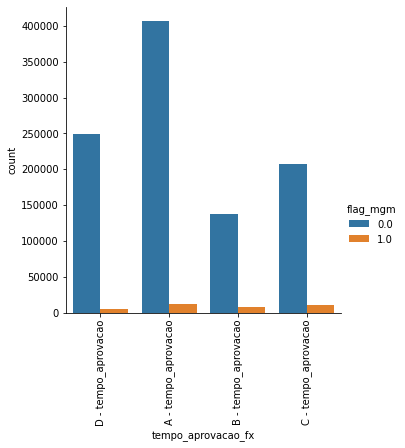

<Figure size 720x360 with 0 Axes>

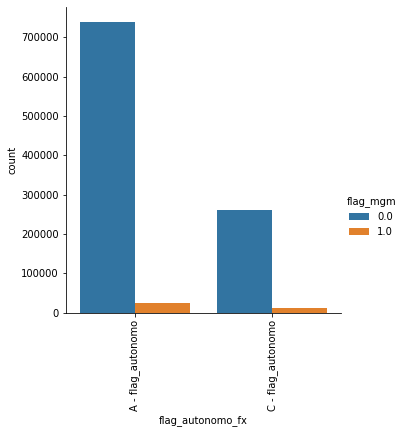

<Figure size 720x360 with 0 Axes>

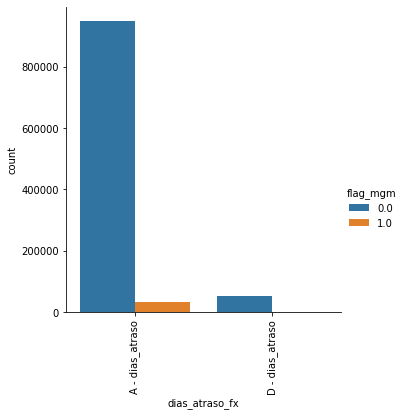

<Figure size 720x360 with 0 Axes>

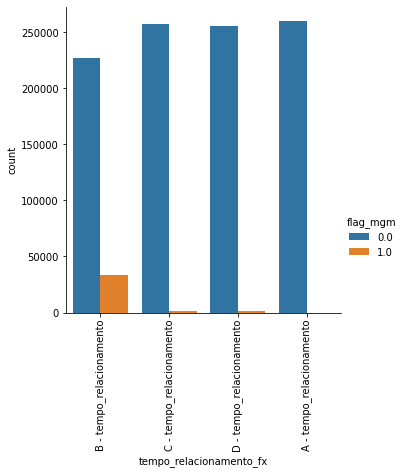

<Figure size 720x360 with 0 Axes>

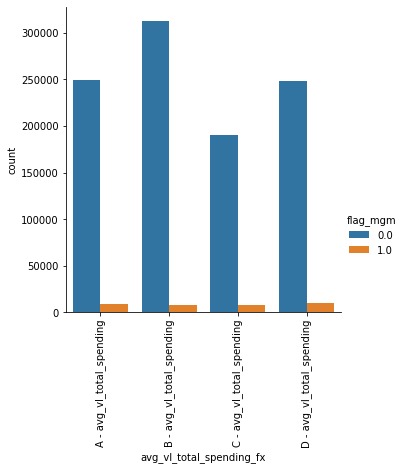

<Figure size 720x360 with 0 Axes>

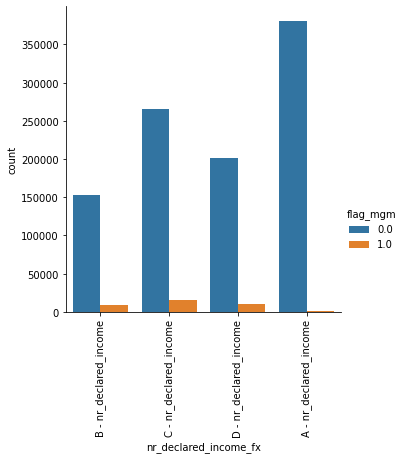

<Figure size 720x360 with 0 Axes>

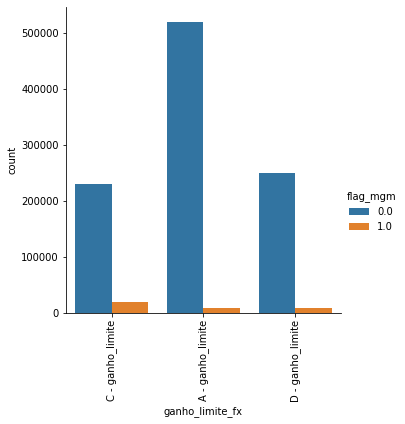

<Figure size 720x360 with 0 Axes>

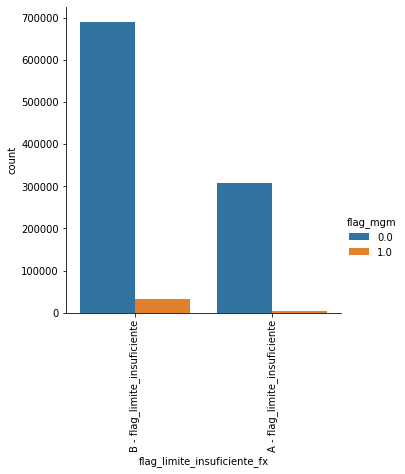

<Figure size 720x360 with 0 Axes>

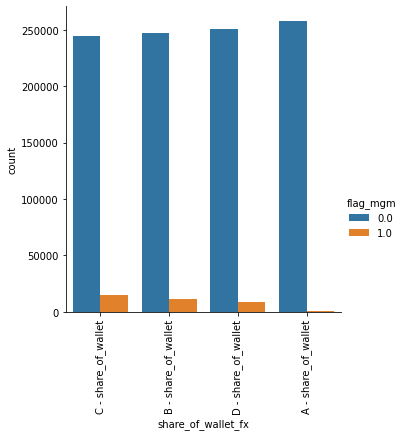

<Figure size 720x360 with 0 Axes>

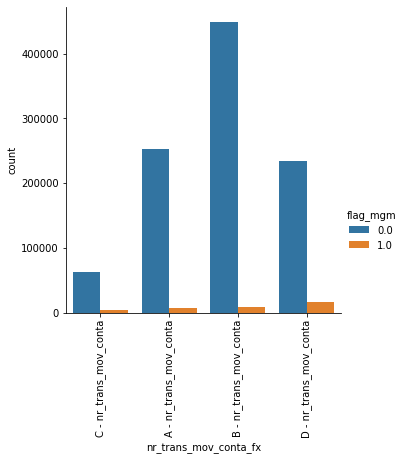

<Figure size 720x360 with 0 Axes>

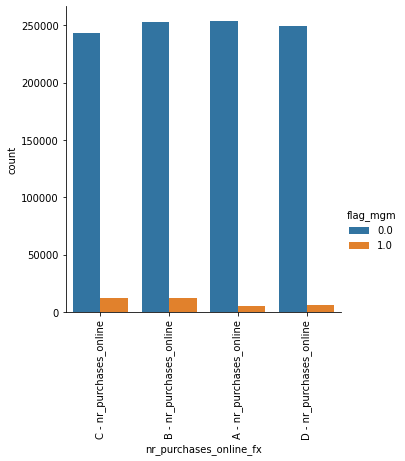

In [23]:
cols_analise = ['tempo_aprovacao_fx',
       'flag_autonomo_fx', 'dias_atraso_fx', 'tempo_relacionamento_fx',
       'avg_vl_total_spending_fx', 'nr_declared_income_fx', 'ganho_limite_fx',
       'flag_limite_insuficiente_fx', 'share_of_wallet_fx',
       'nr_trans_mov_conta_fx', 'nr_purchases_online_fx']

for column in cols_analise:
        plt.figure(figsize = (10,5))
        sns.catplot(x=column, hue='flag_mgm', data=df, kind="count")
        plt.xticks(rotation=90)
        plt.show()

#### Combinar

- Compras online entre P25 e P75
- Movimentação conta acima de P75
- Share of wallet acima de P25
- Ganho limite entre P25 e P75
- Renda declarada acima de P50
- Spending acima da mediana
- Atraso sim ou não
- Tempo de relacionamento entre P25 e P75
- Autonomo sim ou não
- Tempo de aprovação até P25


 Legendas : A - Até P25 ;  B - Entre P25 e P50 ; C - Entre P50 e P75 e D - Acima de P75 * 

In [24]:
df.columns

Index(['cpf', 'tempo_aprovacao', 'tempo_relacionamento', 'ganho_limite',
       'ds_risk_type', 'gender', 'nr_declared_income', 'ds_region',
       'flag_autonomo', 'max_limite', 'max_qtd_if', 'avg_utilizado_interno',
       'sum_utilizado_interno', 'avg_utilizado_mercado',
       'sum_utilizado_mercado', 'nr_chaves_importantes',
       'nr_antecipacao_fatura', 'nr_bolso_ativo', 'nr_trans_mov_conta',
       'nr_purchases_virtual', 'avg_vl_total_spending', 'nr_purchases_online',
       'nr_acessos', 'pc_acessos_lojawill', 'flag_mgm', 'dias_atraso', 'ordem',
       'flag_limite_insuficiente', 'share_of_wallet', 'tempo_aprovacao_fx',
       'tempo_relacionamento_fx', 'ganho_limite_fx', 'nr_declared_income_fx',
       'flag_autonomo_fx', 'max_limite_fx', 'max_qtd_if_fx',
       'avg_utilizado_interno_fx', 'sum_utilizado_interno_fx',
       'avg_utilizado_mercado_fx', 'sum_utilizado_mercado_fx',
       'nr_chaves_importantes_fx', 'nr_antecipacao_fatura_fx',
       'nr_bolso_ativo_fx', 'nr_t

In [25]:
df['seg_online'] = np.where(df.nr_purchases_online <=  df.nr_purchases_online.quantile(0.25), 'A', 
                    np.where(df.nr_purchases_online <=  df.nr_purchases_online.quantile(0.75), 'B', 'C'                       
                            ))

df['seg_online'].value_counts()

B    520595
A    259292
C    255997
Name: seg_online, dtype: int64

In [26]:
df[['seg_online', 'flag_mgm']].groupby('seg_online').mean()

,flag_mgm
seg_online,
A,0.020957
B,0.046660
C,0.024059


In [31]:
df['seg_mov_conta'] = np.where(df.nr_trans_mov_conta <=  df.nr_trans_mov_conta.quantile(0.75), 'A', 'B')

df[['seg_mov_conta', 'flag_mgm']].groupby('seg_mov_conta').agg({'flag_mgm':['mean', 'count']})

flag_mgm        
                   mean   count
seg_mov_conta                  
A              0.024382  785008
B              0.066742  250876

In [32]:
df['seg_share_of_wallet'] = np.where(df.share_of_wallet <=  df.share_of_wallet.quantile(0.25), 'A', 'B')

df[['seg_share_of_wallet', 'flag_mgm']].groupby('seg_share_of_wallet').agg({'flag_mgm':['mean', 'count']})

flag_mgm        
                         mean   count
seg_share_of_wallet                  
A                    0.004549  258971
B                    0.044672  776913

In [33]:
df['seg_ganho_limite'] = np.where(df.ganho_limite <=  df.ganho_limite.quantile(0.25), 'A',
                                  np.where(df.ganho_limite <=  df.ganho_limite.quantile(0.75), 'B', 'C'))

df[['seg_ganho_limite', 'flag_mgm']].groupby('seg_ganho_limite').agg({'flag_mgm':['mean', 'count']})

flag_mgm        
                      mean   count
seg_ganho_limite                  
A                 0.016087  528641
B                 0.077947  249426
C                 0.030789  257817

In [35]:
df['seg_renda_declarada'] = np.where(df.nr_declared_income <=  df.nr_declared_income.quantile(0.50), 'A', 'B')

df[['seg_renda_declarada', 'flag_mgm']].groupby('seg_renda_declarada').agg({'flag_mgm':['mean', 'count']})

flag_mgm        
                         mean   count
seg_renda_declarada                  
A                    0.019189  544280
B                    0.051749  491604

In [37]:
df['seg_relacionamento'] = np.where(df.tempo_relacionamento <=  df.tempo_relacionamento.quantile(0.25), 'A',
                                  np.where(df.tempo_relacionamento <=  df.tempo_relacionamento.quantile(0.75), 'B', 'C'))

df[['seg_relacionamento', 'flag_mgm']].groupby('seg_relacionamento').agg({'flag_mgm':['mean', 'count']})

flag_mgm        
                        mean   count
seg_relacionamento                  
A                   0.000015  259593
B                   0.065912  518765
C                   0.006551  257526

In [36]:
df['seg_spending'] = np.where(df.avg_vl_total_spending <=  df.avg_vl_total_spending.quantile(0.50), 'A', 'B')

df[['seg_spending', 'flag_mgm']].groupby('seg_spending').agg({'flag_mgm':['mean', 'count']})

flag_mgm        
                  mean   count
seg_spending                  
A             0.030014  579005
B             0.040505  456879

In [38]:
df['seg_tempo_aprovacao'] = np.where(df.tempo_aprovacao <=  df.tempo_aprovacao.quantile(0.25), 'A', 'B')

df[['seg_tempo_aprovacao', 'flag_mgm']].groupby('seg_tempo_aprovacao').agg({'flag_mgm':['mean', 'count']})

flag_mgm        
                         mean   count
seg_tempo_aprovacao                  
A                    0.029612  418551
B                    0.038051  617333

In [39]:
df['seg_autonomo'] = np.where(df.flag_autonomo == 0, 'A', 'B')
df['seg_atraso'] = np.where(df.dias_atraso == 0, 'A', 'B')

In [40]:
df[['seg_autonomo', 'flag_mgm']].groupby('seg_autonomo').agg({'flag_mgm':['mean', 'count']})

flag_mgm        
                  mean   count
seg_autonomo                  
A             0.032094  764128
B             0.041802  271756

In [41]:
df[['seg_atraso', 'flag_mgm']].groupby('seg_atraso').agg({'flag_mgm':['mean', 'count']})

flag_mgm        
                mean   count
seg_atraso                  
A           0.035147  983286
B           0.025172   52598

In [44]:
df['segmento_v1'] = df.seg_ganho_limite.astype("string") + df.seg_relacionamento.astype("string")

In [45]:
df[['segmento_v1', 'flag_mgm']].groupby('segmento_v1').agg({'flag_mgm':['mean', 'count']})

flag_mgm        
                 mean   count
segmento_v1                  
AA           0.000017  233386
AB           0.052730  148341
AC           0.004615  146914
BA           0.000000   23325
BB           0.095921  201718
BC           0.003814   24383
CA           0.000000    2882
CB           0.041623  168706
CC           0.010623   86229

In [46]:
df['segmento_v2'] = df.segmento_v1.astype("string") + df.seg_mov_conta.astype("string")

In [47]:
df[['segmento_v2', 'flag_mgm']].groupby('segmento_v2').agg({'flag_mgm':['mean', 'count']})

flag_mgm        
                 mean   count
segmento_v2                  
AAA          0.000020  204900
AAB          0.000000   28486
ABA          0.038194  113446
ABB          0.099986   34895
ACA          0.003696  127150
ACB          0.010524   19764
BAA          0.000000   16302
BAB          0.000000    7023
BBA          0.077881  125037
BBB          0.125337   76681
BCA          0.002726   19807
BCB          0.008523    4576
CAA          0.000000    2181
CAB          0.000000     701
CBA          0.035810  113208
CBB          0.053479   55498
CCA          0.007733   62977
CCB          0.018450   23252

In [51]:
df['segmento_v3'] = df.seg_relacionamento.astype("string") + df.seg_share_of_wallet.astype("string") + df.seg_mov_conta.astype("string")
df[['segmento_v3', 'flag_mgm']].groupby('segmento_v3').agg({'flag_mgm':['mean', 'count']})

flag_mgm        
                 mean   count
segmento_v3                  
AAA          0.000018  112854
AAB          0.000000    4176
ABA          0.000018  110529
ABB          0.000000   32034
BAA          0.012844   66722
BAB          0.049711    4325
BBA          0.060596  284969
BBB          0.097408  162749
CAA          0.001130   69917
CAB          0.025589     977
CBA          0.006656  140017
CBB          0.013965   46615

Descartar a versão 3 - não funcionou combinando relacioniamento + share of wallet OU Spending OU Movimentação de conta

Próximos passos:

- Unificar a v2 para uma versão final - abrindo só quando houver diferença na taxa de mgm
- Identificar grupos grandes, filtrar e abrir pelas outras variáveis (dividir para conquistar)

In [56]:
df['segmento_v4'] = np.where(df.seg_relacionamento == "A", "0. Pouco tempo de relacionamento",
np.where(df.seg_relacionamento.astype("string") + df.seg_mov_conta.astype("string") == "CA", "0. Alto Tempo de Relac - Pouco Movimento Conta",
np.where(df.segmento_v2 == "ABA", "2. Tempo de Relac Mediano - Pouco aumento limite - Pouco Movimento Conta",
np.where(df.segmento_v2 == "ABB", "4. Tempo de Relac Mediano - Pouco aumento limite - Alto Movimento Conta",
np.where(df.segmento_v2 == "BBB", "5. Tempo de Relac Mediano - Aumento limite mediano - Alto Movimento Conta",
np.where(df.segmento_v2 == "ACB", "1. Alto Tempo de Relac - Pouco aumento limite - Alto Movimento Conta",
np.where(df.segmento_v2 == "CCB", "1. Alto Tempo de Relac - Alto aumento de limite - Alto Movimento Conta",
np.where(df.segmento_v2 == "BCB", "0. Alto Tempo de Relac - Aumento limite mediano - Alto Movimento Conta",
np.where(df.segmento_v2 == "BBA", "3. Tempo de Relac Mediano - Aumento limite mediano - Pouco Movimento Conta",
np.where(df.segmento_v2 == "CBA", "2. Tempo de Relac Mediano - Aumento limite mediano - Baixo Movimento Conta",
np.where(df.segmento_v2 == "CBB", "3. Tempo de Relac Mediano - Alto aumento limite - Alto Movimento Conta", "NI")))))))))))

df[['segmento_v4', 'flag_mgm']].groupby('segmento_v4').agg({'flag_mgm':['mean', 'count']})

flag_mgm        
                                                        mean   count
segmento_v4                                                         
0. Alto Tempo de Relac - Aumento limite mediano...  0.008523    4576
0. Alto Tempo de Relac - Pouco Movimento Conta      0.004816  209934
0. Pouco tempo de relacionamento                    0.000015  259593
1. Alto Tempo de Relac - Alto aumento de limite...  0.018450   23252
1. Alto Tempo de Relac - Pouco aumento limite -...  0.010524   19764
2. Tempo de Relac Mediano - Aumento limite medi...  0.035810  113208
2. Tempo de Relac Mediano - Pouco aumento limit...  0.038194  113446
3. Tempo de Relac Mediano - Alto aumento limite...  0.053479   55498
3. Tempo de Relac Mediano - Aumento limite medi...  0.077881  125037
4. Tempo de Relac Mediano - Pouco aumento limit...  0.099986   34895
5. Tempo de Relac Mediano - Aumento limite medi...  0.125337   76681

- A indicação aumenta as chances de aumento de limite? Isso é comunicado?

In [57]:
df.query('segmento_v4 == "NI"')['segmento_v2'].value_counts()

Series([], Name: segmento_v2, dtype: Int64)

Abrir:

- 0. Pouco tempo de relacionamento
- 0. Alto Tempo de Relac - Pouco Movimento Conta
- 2. Tempo de Relac Mediano - Pouco aumento limite - Pouco Movimento Conta

<Figure size 720x360 with 0 Axes>

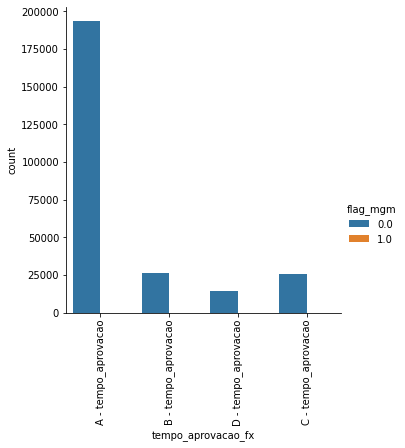

<Figure size 720x360 with 0 Axes>

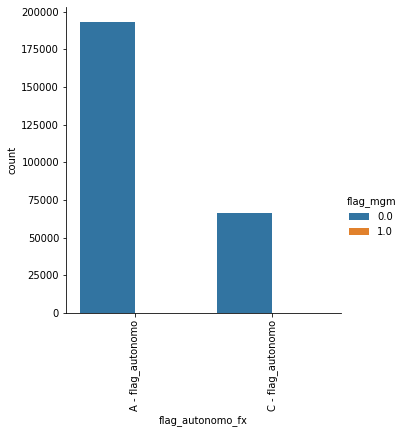

<Figure size 720x360 with 0 Axes>

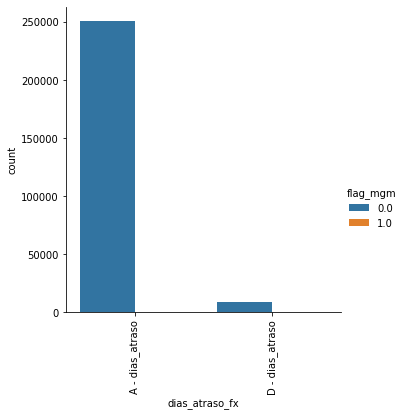

<Figure size 720x360 with 0 Axes>

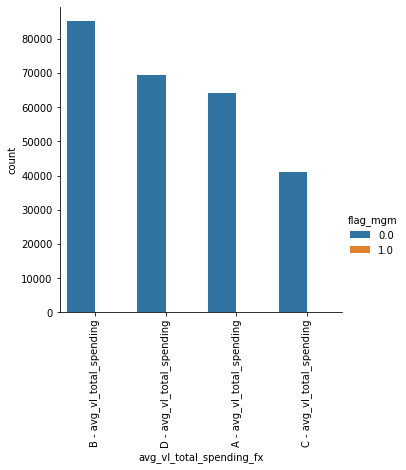

<Figure size 720x360 with 0 Axes>

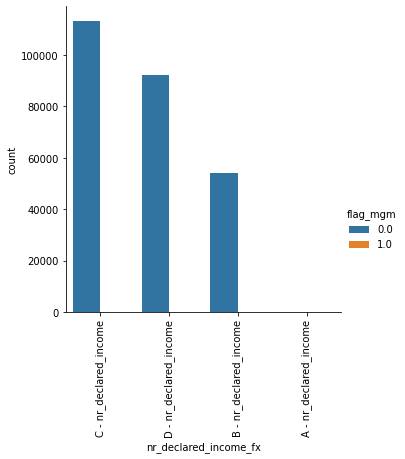

<Figure size 720x360 with 0 Axes>

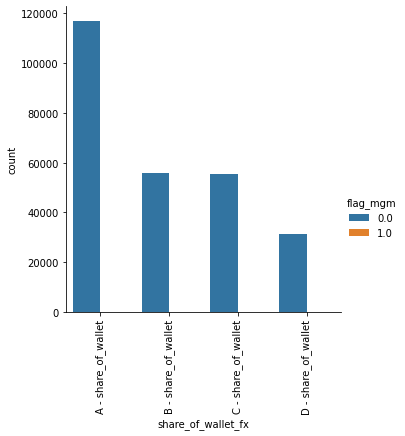

<Figure size 720x360 with 0 Axes>

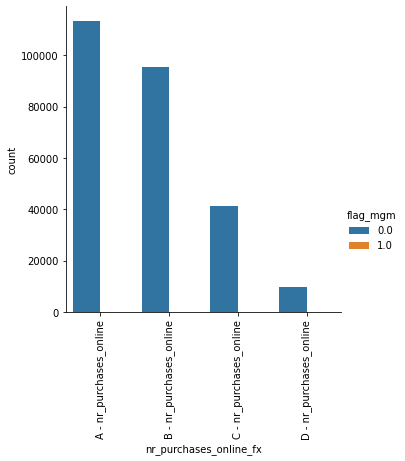

In [58]:
cols_analise = ['tempo_aprovacao_fx', 'flag_autonomo_fx', 'dias_atraso_fx', 
                'avg_vl_total_spending_fx', 'nr_declared_income_fx', 'share_of_wallet_fx', 'nr_purchases_online_fx']


df_temp = df.query('segmento_v4 == "0. Pouco tempo de relacionamento"')

for column in cols_analise:
        plt.figure(figsize = (10,5))
        sns.catplot(x=column, hue='flag_mgm', data=df_temp, kind="count")
        plt.xticks(rotation=90)
        plt.show()

In [61]:
df.query('segmento_v4 == "0. Alto Tempo de Relac - Pouco Movimento Conta"')[['flag_mgm', 'seg_spending']] \
.groupby('seg_spending').agg({'flag_mgm':['mean', 'count']})

flag_mgm        
                  mean   count
seg_spending                  
A             0.001554  124848
B             0.009602   85086

In [62]:
df.query('segmento_v4 == "0. Alto Tempo de Relac - Pouco Movimento Conta"')[['flag_mgm', 'seg_share_of_wallet']] \
.groupby('seg_share_of_wallet').agg({'flag_mgm':['mean', 'count']})

flag_mgm        
                         mean   count
seg_share_of_wallet                  
A                    0.001130   69917
B                    0.006656  140017

<Figure size 720x360 with 0 Axes>

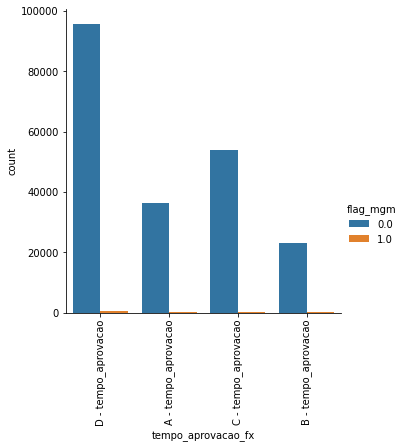

<Figure size 720x360 with 0 Axes>

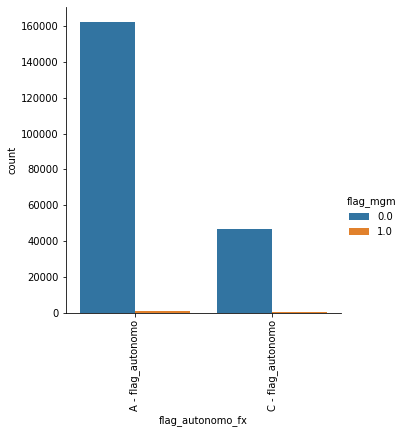

<Figure size 720x360 with 0 Axes>

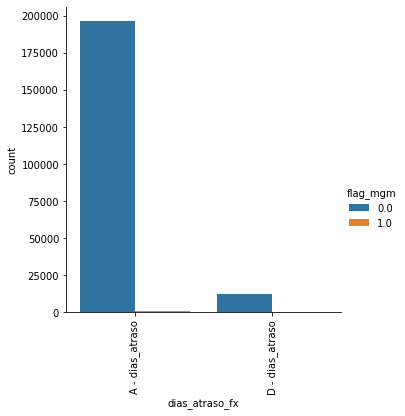

<Figure size 720x360 with 0 Axes>

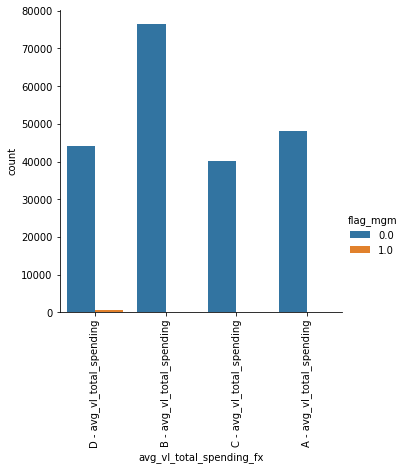

<Figure size 720x360 with 0 Axes>

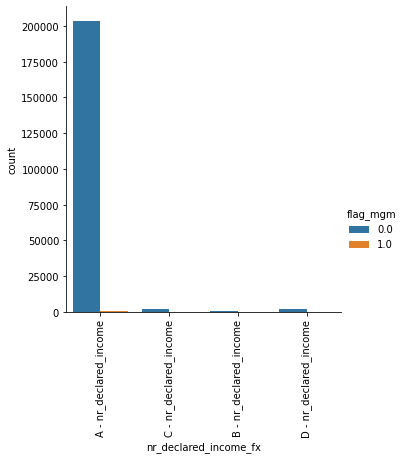

<Figure size 720x360 with 0 Axes>

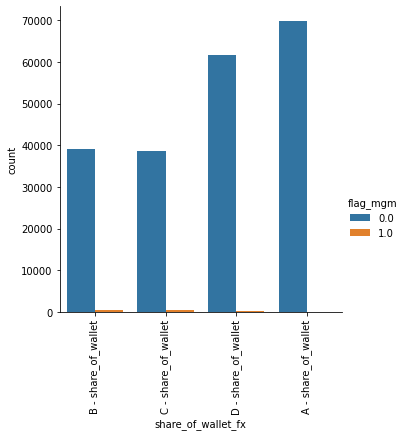

<Figure size 720x360 with 0 Axes>

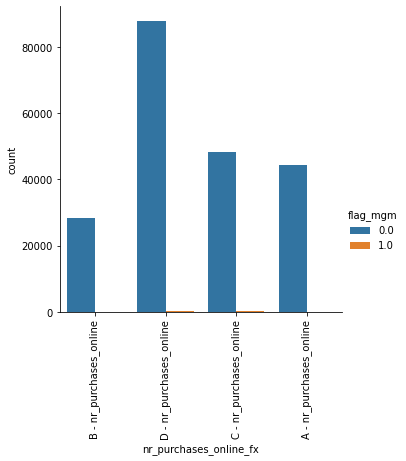

In [59]:
df_temp = df.query('segmento_v4 == "0. Alto Tempo de Relac - Pouco Movimento Conta"')

for column in cols_analise:
        plt.figure(figsize = (10,5))
        sns.catplot(x=column, hue='flag_mgm', data=df_temp, kind="count")
        plt.xticks(rotation=90)
        plt.show()

<Figure size 720x360 with 0 Axes>

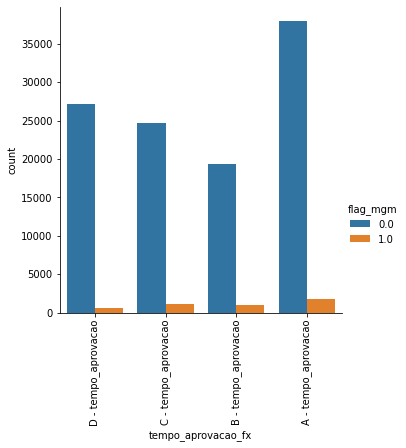

<Figure size 720x360 with 0 Axes>

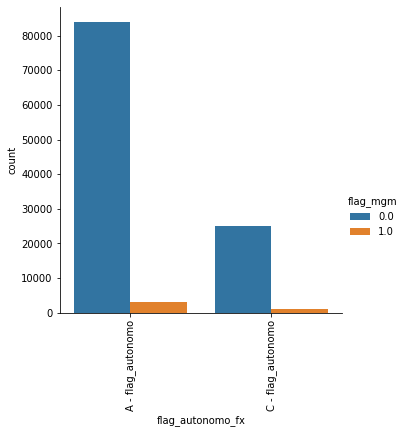

<Figure size 720x360 with 0 Axes>

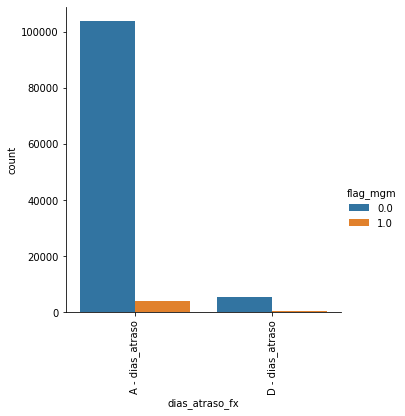

<Figure size 720x360 with 0 Axes>

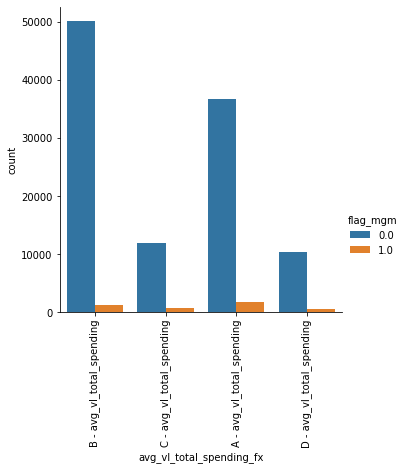

<Figure size 720x360 with 0 Axes>

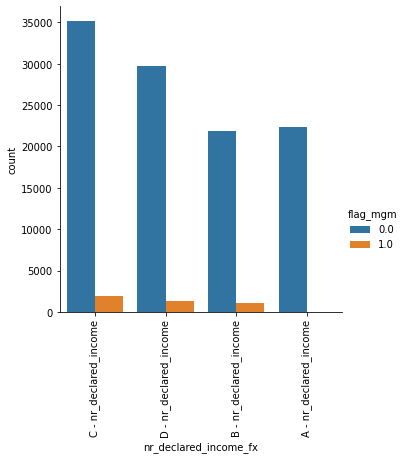

<Figure size 720x360 with 0 Axes>

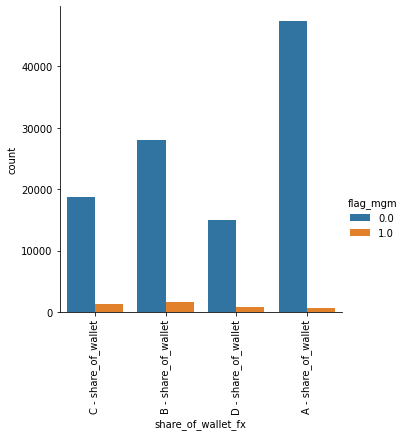

<Figure size 720x360 with 0 Axes>

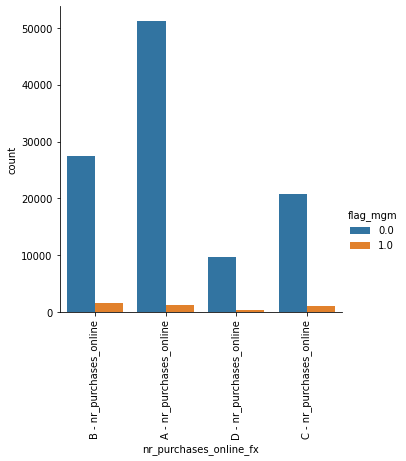

In [63]:
df_temp = df.query('segmento_v4 == "2. Tempo de Relac Mediano - Pouco aumento limite - Pouco Movimento Conta"')

for column in cols_analise:
        plt.figure(figsize = (10,5))
        sns.catplot(x=column, hue='flag_mgm', data=df_temp, kind="count")
        plt.xticks(rotation=90)
        plt.show()

In [64]:
df.query('segmento_v4 == "2. Tempo de Relac Mediano - Pouco aumento limite - Pouco Movimento Conta"')[['flag_mgm', 'seg_share_of_wallet']] \
.groupby('seg_share_of_wallet').agg({'flag_mgm':['mean', 'count']})

flag_mgm       
                         mean  count
seg_share_of_wallet                 
A                    0.012658  48034
B                    0.056947  65412

O segmento_v2 ABA, no consolidado tinha share de 0.038194


Na abertura de share of wallet
B = 3
A = 1





# variaveis finais


df['seg_relacionamento'] = np.where(df.tempo_relacionamento <=  df.tempo_relacionamento.quantile(0.25), 'A',
                                  np.where(df.tempo_relacionamento <=  df.tempo_relacionamento.quantile(0.75), 'B', 'C'))




seg_relacionamento
seg_mov_conta
seg_share_of_wallet
seg_ganho_limite
segmento_v2 = df.seg_ganho_limite.astype("string") + df.seg_relacionamento.astype("string") + df.seg_mov_conta.astype("string")


In [67]:
df['segmento_v5'] = np.where(df.seg_relacionamento == "A", "0. Pouco tempo de relacionamento",
np.where(df.seg_relacionamento.astype("string") + df.seg_mov_conta.astype("string") == "CA", "0. Alto Tempo de Relac - Pouco Movimento Conta",
#Abrir por share of wallet
np.where((df.segmento_v2 == "ABA") & (df.seg_share_of_wallet == "A"), "1. Tempo de Relac Mediano - Pouco aumento limite - Pouco Mov Conta - Baixo SOW", 
np.where((df.segmento_v2 == "ABA") & (df.seg_share_of_wallet == "B"), "3. Tempo de Relac Mediano - Pouco aumento limite - Pouco Mov Conta - Alto SOW",
np.where(df.segmento_v2 == "ABB", "4. Tempo de Relac Mediano - Pouco aumento limite - Alto Movimento Conta",
np.where(df.segmento_v2 == "BBB", "5. Tempo de Relac Mediano - Aumento limite mediano - Alto Movimento Conta",
np.where(df.segmento_v2 == "ACB", "1. Alto Tempo de Relac - Pouco aumento limite - Alto Movimento Conta",
np.where(df.segmento_v2 == "CCB", "1. Alto Tempo de Relac - Alto aumento de limite - Alto Movimento Conta",
np.where(df.segmento_v2 == "BCB", "0. Alto Tempo de Relac - Aumento limite mediano - Alto Movimento Conta",
np.where(df.segmento_v2 == "BBA", "4. Tempo de Relac Mediano - Aumento limite mediano - Pouco Movimento Conta",
np.where(df.segmento_v2 == "CBA", "2. Tempo de Relac Mediano - Aumento limite mediano - Baixo Movimento Conta",
np.where(df.segmento_v2 == "CBB", "3. Tempo de Relac Mediano - Alto aumento limite - Alto Movimento Conta", "NI"))))))))))))

df[['segmento_v5', 'flag_mgm']].groupby('segmento_v5').agg({'flag_mgm':['mean', 'count']})

flag_mgm        
                                                        mean   count
segmento_v5                                                         
0. Alto Tempo de Relac - Aumento limite mediano...  0.008523    4576
0. Alto Tempo de Relac - Pouco Movimento Conta      0.004816  209934
0. Pouco tempo de relacionamento                    0.000015  259593
1. Alto Tempo de Relac - Alto aumento de limite...  0.018450   23252
1. Alto Tempo de Relac - Pouco aumento limite -...  0.010524   19764
1. Tempo de Relac Mediano - Pouco aumento limit...  0.012658   48034
2. Tempo de Relac Mediano - Aumento limite medi...  0.035810  113208
3. Tempo de Relac Mediano - Alto aumento limite...  0.053479   55498
3. Tempo de Relac Mediano - Pouco aumento limit...  0.056947   65412
4. Tempo de Relac Mediano - Aumento limite medi...  0.077881  125037
4. Tempo de Relac Mediano - Pouco aumento limit...  0.099986   34895
5. Tempo de Relac Mediano - Aumento limite medi...  0.125337   76681

In [68]:
df[['segmento_v5', 'tempo_relacionamento']].groupby('segmento_v5').agg({'tempo_relacionamento':['mean', 'min', 'max']})

tempo_relacionamento  \
                                                                   mean   
segmento_v5                                                               
0. Alto Tempo de Relac - Aumento limite mediano...          1504.578671   
0. Alto Tempo de Relac - Pouco Movimento Conta              1714.447522   
0. Pouco tempo de relacionamento                              94.263262   
1. Alto Tempo de Relac - Alto aumento de limite...          1529.185618   
1. Alto Tempo de Relac - Pouco aumento limite -...          1865.712862   
1. Tempo de Relac Mediano - Pouco aumento limit...           721.869322   
2. Tempo de Relac Mediano - Aumento limite medi...           883.816577   
3. Tempo de Relac Mediano - Alto aumento limite...           863.985189   
3. Tempo de Relac Mediano - Pouco aumento limit...           599.984315   
4. Tempo de Relac Mediano - Aumento limite medi...           613.933516   
4. Tempo de Relac Mediano - Pouco aumento limit...           580.665654   
5. Tempo de Relac Mediano - Aumento limite medi...           585.395378   

                                                                    
                                                       min     max  
segmento_v5                                                         
0. Alto Tempo de Relac - Aumento limite mediano...  1346.0  2260.0  
0. Alto Tempo de Relac - Pouco Movimento Conta      1346.0  2309.0  
0. Pouco tempo de relacionamento                       1.0   218.0  
1. Alto Tempo de Relac - Alto aumento de limite...  1346.0  2308.0  
1. Alto Tempo de Relac - Pouco aumento limite -...  1346.0  2308.0  
1. Tempo de Relac Mediano - Pouco aumento limit...   219.0  1345.0  
2. Tempo de Relac Mediano - Aumento limite medi...   219.0  1345.0  
3. Tempo de Relac Mediano - Alto aumento limite...   219.0  1345.0  
3. Tempo de Relac Mediano - Pouco aumento limit...   219.0  1345.0  
4. Tempo de Relac Mediano - Aumento limite medi...   219.0  1345.0  
4. Tempo de Relac Mediano - Pouco aumento limit...   219.0  1345.0  
5. Tempo de Relac Mediano - Aumento limite medi...   219.0  1345.0